In [6]:
import random 
from random import sample, seed, shuffle
import numpy as np
import pandas as pd
import os
import six
from rdkit import rdBase
from rdkit import RDLogger

# Suppress RDKit warnings
rdBase.DisableLog('rdApp.*')
RDLogger.DisableLog('rdApp.*')

#utility functions : prepare the data 
from model_fp_selection.lib.utils import prepare_df_morgan, prepare_df_rdkit, swap_identical_ligands, prepare_df_chemeleon
from model_fp_selection.lib.utils import drop_duplicates, average_duplicates

#utility functions : CV and results 
from model_fp_selection.lib.utils import obtain_metrics, plot_cv_results
from model_fp_selection.lib.utils import df_split, get_indices, get_indices_doi, get_indices_scaff
from model_fp_selection.lib.utils import generate_scaffold, scaffold_to_smiles
from model_fp_selection.lib.utils import ligands_permutation, cross_validation, prepare_train_set


from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, Draw
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error, PredictionErrorDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import MinMaxScaler

#Encoding categorical Data
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Regressors
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

#Pipelines and other model constructions
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

# Visualization
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

#np.random.seed(42)
#seed(42)

#Specific to Scaffold Splitting
from rdkit.Chem.Scaffolds import MurckoScaffold
from collections import defaultdict
import pickle as pkl
import time
from tqdm import tqdm
import seaborn as sns

from itertools import *

In [7]:
metals = pd.read_csv("ruthenium_complexes_dataset.csv", dtype={'L1': str, 'L2': str, 'L3': str})

In [8]:
metals_rdkit = prepare_df_rdkit(metals)

In [9]:
metals_rdkit = average_duplicates(metals_rdkit, 'Ligands_Dict', 'pIC50')

Length of training dataset after cleaning duplicates, before adding permutations : 718


# Training the model

Bayesian Optimisation allowed us to get the best hyperparameters for the random forest model, depending on the Fingerprint used.

### Random Splitting

In [13]:
rf_rdkit = RandomForestRegressor(max_depth=15, n_estimators=50, min_samples_leaf=1, max_features=0.5, random_state=42)

#### On the whole dataset, RDKit fingerprint

In [11]:
metals_rdkit_copy = metals_rdkit.copy()
metals_rdkit_copy.reset_index(drop=True, inplace=True)

X = np.array(metals_rdkit_copy['Fingerprint'].values.tolist())
y = np.array(metals_rdkit_copy['pIC50'].values.tolist())

indices_rdkit = get_indices(metals_rdkit_copy, CV=10, shuffle=True)

train length : 646 | test length : 72
train length : 646 | test length : 72
train length : 646 | test length : 72
train length : 646 | test length : 72
train length : 646 | test length : 72
train length : 646 | test length : 72
train length : 646 | test length : 72
train length : 646 | test length : 72
train length : 647 | test length : 71
train length : 647 | test length : 71


In [12]:
y_data_rdkit, y_predictions_rdkit = cross_validation(metals_rdkit_copy, indices_rdkit, X, y, rf_rdkit)

CV iteration 0
CV iteration 1
CV iteration 2
CV iteration 3
CV iteration 4
CV iteration 5
CV iteration 6
CV iteration 7
CV iteration 8
CV iteration 9
{'MAE': 0.3281813006419524, 'RMSE': 0.45184787170233065, 'Ratio': 1.3768239409694436, 'R² Score': 0.7065172178001324}


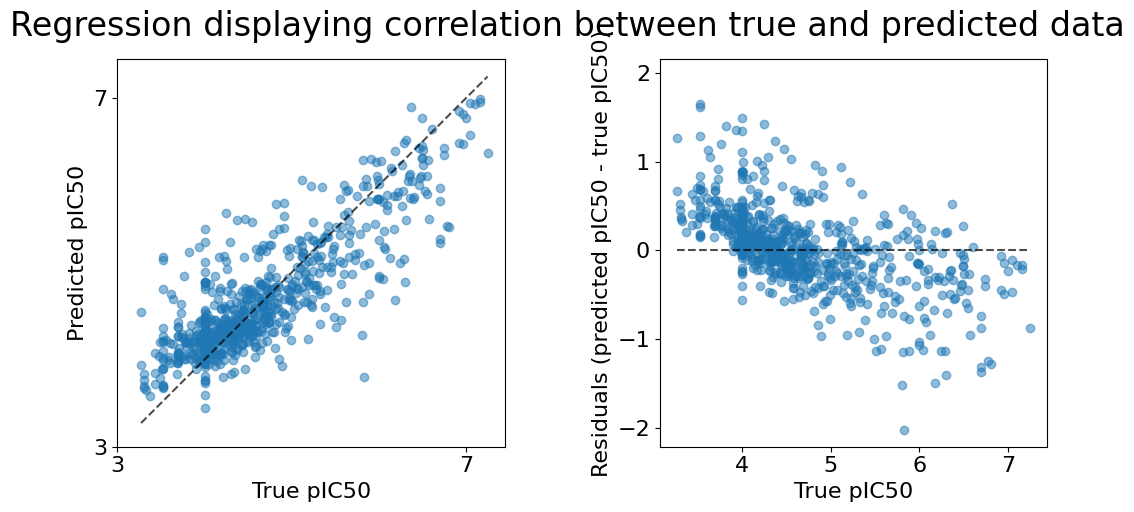

In [13]:
plot_cv_results(y_data_rdkit, y_predictions_rdkit, log=True)

#### On HeLa, RDKit fingerprint

In [17]:
metals_rdkit_hela = metals_rdkit.copy()
metals_rdkit_hela = metals_rdkit_hela[metals_rdkit_hela['Cells'] == 'HeLa']
metals_rdkit_hela.reset_index(drop=True, inplace=True)

X_hela = np.array(metals_rdkit_hela['Fingerprint'].values.tolist())
y_hela = np.array(metals_rdkit_hela['pIC50'].values.tolist())

indices_rdkit_hela = get_indices(metals_rdkit_hela, CV=10, shuffle=True)

train length : 164 | test length : 19
train length : 164 | test length : 19
train length : 164 | test length : 19
train length : 165 | test length : 18
train length : 165 | test length : 18
train length : 165 | test length : 18
train length : 165 | test length : 18
train length : 165 | test length : 18
train length : 165 | test length : 18
train length : 165 | test length : 18


In [18]:
y_data_rdkit_hela, y_predictions_rdkit_hela = cross_validation(metals_rdkit_hela, indices_rdkit_hela, X_hela, y_hela, rf_rdkit)

CV iteration 0
CV iteration 1
CV iteration 2
CV iteration 3
CV iteration 4
CV iteration 5
CV iteration 6
CV iteration 7
CV iteration 8
CV iteration 9
{'MAE': 0.26893215500487955, 'RMSE': 0.40047025715984524, 'Ratio': 1.489112587345976, 'R² Score': 0.48984746507025456}


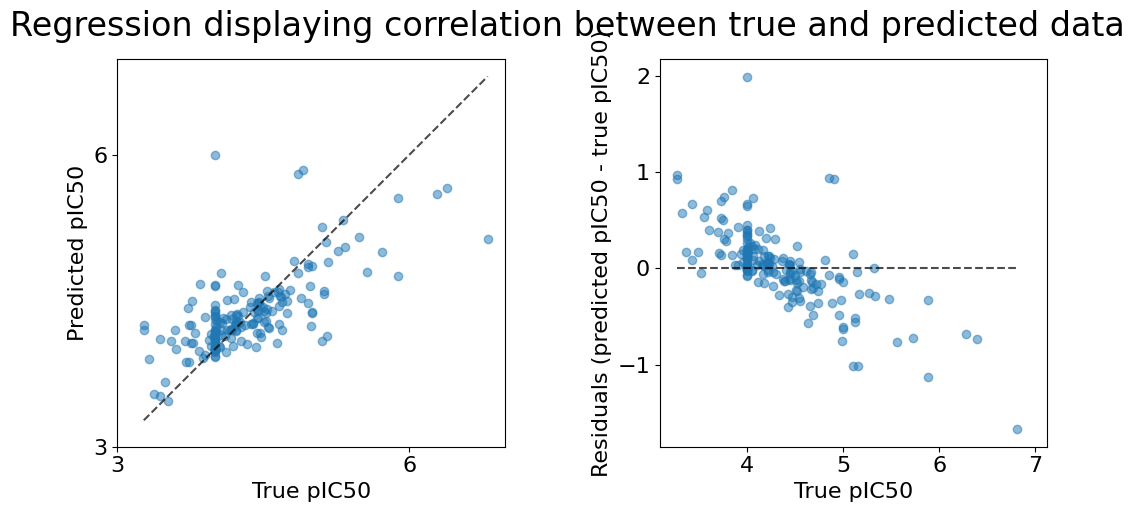

In [19]:
plot_cv_results(y_data_rdkit_hela, y_predictions_rdkit_hela, log=True)

## DOI Splitting

#### On the whole dataset, RDKit fingerprint

In [6]:
metals_rdkit_doi = metals_rdkit.copy()
metals_rdkit_doi.reset_index(drop=True, inplace=True)

X_rdkit_doi = np.array(metals_rdkit_doi['Fingerprint'].values.tolist())
y_rdkit_doi = np.array(metals_rdkit_doi['pIC50'].values.tolist())

indices_rdkit_doi = get_indices_doi(metals_rdkit_doi, CV=10)

fold 0 groups: train 200 test 20
fold 0 train set : 646 | test set : 72
fold 1 groups: train 198 test 22
fold 1 train set : 646 | test set : 72
fold 2 groups: train 198 test 22
fold 2 train set : 646 | test set : 72
fold 3 groups: train 198 test 22
fold 3 train set : 646 | test set : 72
fold 4 groups: train 198 test 22
fold 4 train set : 646 | test set : 72
fold 5 groups: train 198 test 22
fold 5 train set : 646 | test set : 72
fold 6 groups: train 197 test 23
fold 6 train set : 646 | test set : 72
fold 7 groups: train 197 test 23
fold 7 train set : 646 | test set : 72
fold 8 groups: train 198 test 22
fold 8 train set : 647 | test set : 71
fold 9 groups: train 198 test 22
fold 9 train set : 647 | test set : 71


In [10]:
y_data_rdkit_doi, y_predictions_rdkit_doi = cross_validation(metals_rdkit_doi, indices_rdkit_doi, X_rdkit_doi, y_rdkit_doi, rf_rdkit)

CV iteration 0
CV iteration 1
CV iteration 2
CV iteration 3
CV iteration 4
CV iteration 5
CV iteration 6
CV iteration 7
CV iteration 8
CV iteration 9
{'MAE': 0.5366724774327194, 'RMSE': 0.7307852907951169, 'Ratio': 1.3616969781848607, 'R² Score': 0.23232439464307453}


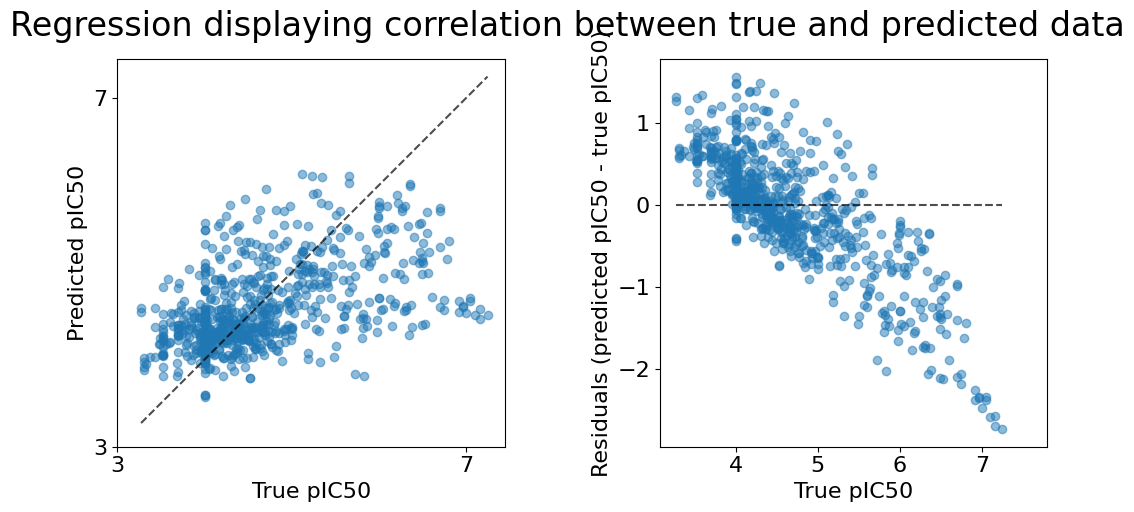

In [15]:
plot_cv_results(y_data_rdkit_doi, y_predictions_rdkit_doi, log=True)

## Scaffold Splitting

Whenever the complexe presents a AAB structure, it has been canonicalized in the 'prepare_df' function, so that any complexes represented as ABA or BAA is put in the form AAB.

### Scaffold A

In [16]:
def generate_scaffold(mol, include_chirality=False):
    """
    Computes the Bemis-Murcko scaffold for a SMILES string.

    Args:
        mol (RDkit mol): A SMILES string or an RDKit molecule.
        include_chirality (bool): Whether to include chirality.
    
    returns:
        scaffold (RDKit mol)
    """
    scaffold = MurckoScaffold.MurckoScaffoldSmiles(mol=mol, includeChirality=include_chirality)

    return scaffold

def groupkfold_by_scaffold(df, mol_col='MOL1', n_splits=10, y_col='pIC50'):
    """
    Run GroupKFold using scaffold groups computed from `mol_col`.
    - mol_col: column holding SMILES or RDKit Mol objects for which generate_scaffold(mol) works
    - returns: list of [train_index_list, test_index_list] for each fold (same format as your DOI code)
    """
    # Make sure generate_scaffold is available and deterministic
    # Create scaffold column (one label per sample)
    df = df.copy()
    df['scaffold'] = df[mol_col].apply(generate_scaffold)

    X = df.drop(columns=[y_col])
    X = X.sample(frac=1, random_state=42)
    y = df[y_col].values
    groups = np.array(df['scaffold'].tolist())

    gkf = GroupKFold(n_splits=n_splits)
    tr_te = []

    for fold, (tr, te) in enumerate(gkf.split(X, y, groups)):
        train_df = df.iloc[tr]
        test_df  = df.iloc[te]
        # check: no overlap in scaffold ids
        assert set(train_df['scaffold']).isdisjoint(set(test_df['scaffold']))
        print(f"fold {fold} groups: train {train_df['scaffold'].nunique()} test {test_df['scaffold'].nunique()}")
        print(f"fold {fold} train set : {len(train_df)} | test set : {len(test_df)}")
        tr_te.append([train_df.index.tolist(), test_df.index.tolist()])

    return tr_te

#### Scaffold for ligand A, RDKit Fingerprint

In [12]:
metals_A = metals_rdkit.copy()
metals_A.reset_index(drop=True, inplace=True)

X_A = np.array(metals_A['Fingerprint'].values.tolist())
y_A = np.array(metals_A['pIC50'].values.tolist())

# We must extract the mol objects as the get_indices_scaff take a list of mol objects as argument, not a dataframe
molsA = metals_A['MOL1'].tolist()

indicesA = get_indices_scaff(molsA, CV=10)

100%|█████████████████████████████████████████████████████████████████████████████| 718/718 [00:00<00:00, 11378.92it/s]

train length : 651 | test length : 67
train length : 689 | test length : 29
train length : 684 | test length : 34
train length : 701 | test length : 17
train length : 706 | test length : 12
train length : 712 | test length : 6
train length : 507 | test length : 211
train length : 705 | test length : 13
train length : 709 | test length : 9
train length : 398 | test length : 320


In [13]:
y_dataA, y_predictionsA = cross_validation(metals_A, indicesA, X_A, y_A, rf_rdkit)

CV iteration 0
CV iteration 1
CV iteration 2
CV iteration 3
CV iteration 4
CV iteration 5
CV iteration 6
CV iteration 7
CV iteration 8
CV iteration 9
{'MAE': 0.5126114237372614, 'RMSE': 0.7261122056209178, 'Ratio': 1.4164963401070945, 'R² Score': 0.2421109721351148}


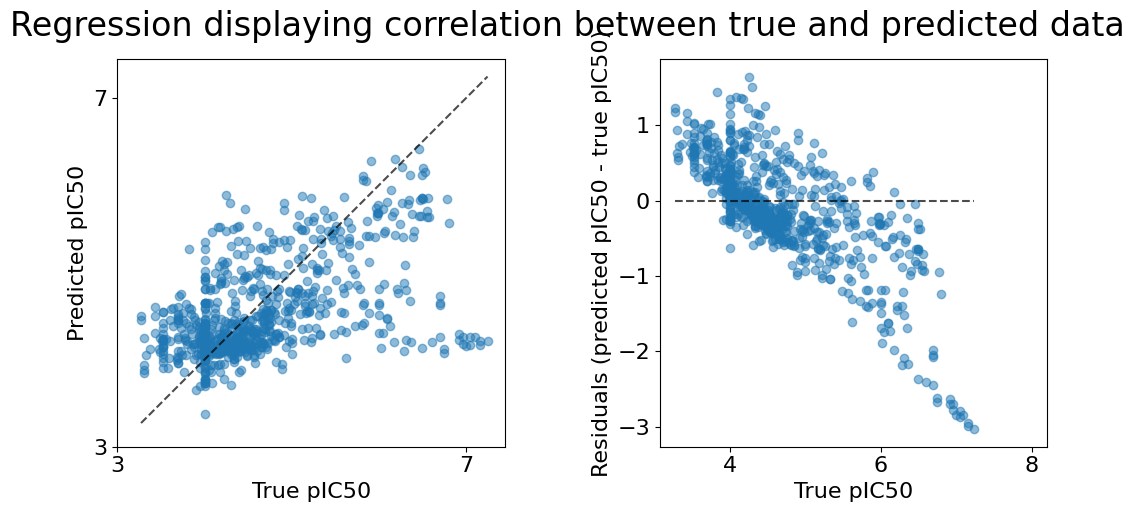

In [14]:
plot_cv_results(y_dataA, y_predictionsA, log=True)

#### Scaffold for ligand B, RDKit Fingerprint

In [17]:
metals_B = metals_rdkit.copy()
metals_B.reset_index(drop=True, inplace=True)

X_B = np.array(metals_B['Fingerprint'].values.tolist())
y_B = np.array(metals_B['pIC50'].values.tolist())

# We must extract the mol objects as the get_indices_scaff take a list of mol objects as argument, not a dataframe
molsB = metals_B['MOL3'].tolist()

indicesB = get_indices_scaff(molsB, CV=10)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 718/718 [00:00<00:00, 5704.39it/s]

train length : 676 | test length : 42
train length : 577 | test length : 141
train length : 672 | test length : 46
train length : 594 | test length : 124
train length : 673 | test length : 45
train length : 677 | test length : 41
train length : 601 | test length : 117
train length : 647 | test length : 71
train length : 674 | test length : 44
train length : 671 | test length : 47


In [18]:
y_dataB, y_predictionsB = cross_validation(metals_B, indicesB, X_B, y_B, rf_rdkit)

CV iteration 0
CV iteration 1
CV iteration 2
CV iteration 3
CV iteration 4
CV iteration 5
CV iteration 6
CV iteration 7
CV iteration 8
CV iteration 9
{'MAE': 0.4810454483320736, 'RMSE': 0.642007329980847, 'Ratio': 1.3346084703781642, 'R² Score': 0.4075139647028513}


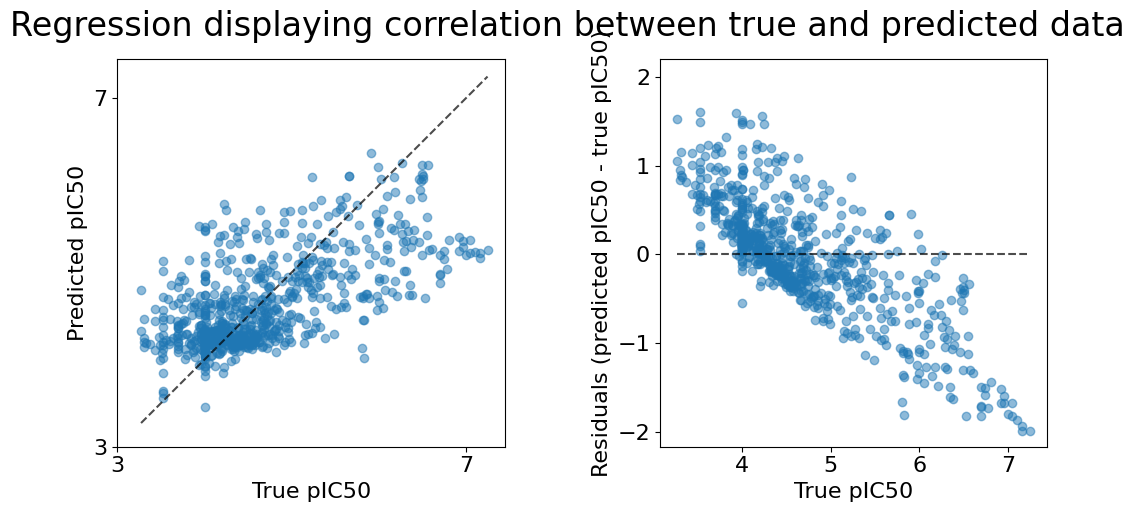

In [20]:
plot_cv_results(y_dataB, y_predictionsB, log=True)